In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import sys
sys.path.append('..')
from utils import plot_iters, plot_coverage_all
warnings.filterwarnings("ignore")
from collections import Counter
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

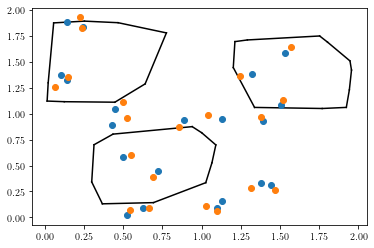

In [2]:
m = 20
np.random.seed(5)
distribution = np.random.dirichlet(np.exp(np.random.normal(size =m)))
np.random.seed(16)
poi = np.random.rand(m, 2)*2
purts = np.random.uniform(-1,1, (m, 2))*0.1
newpoints = poi + purts

from scipy.spatial import ConvexHull, convex_hull_plot_2d
rng = np.random.default_rng()
np.random.seed(1)
points = np.random.rand(30, 2)*0.8 + np.array((0.3,0.1))  # 30 random points in 2-D
hull = ConvexHull(points)
points1= np.random.rand(30, 2)*0.8 + np.array((1.2,0.95))   # 30 random points in 2-D
hull1 = ConvexHull(points1)
points2= np.random.rand(30, 2)*0.8 + np.array((0,1.1))   # 30 random points in 2-D
hull2 = ConvexHull(points2)
# plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1],'k-')
# plt.plot(points1[:,0], points1[:,1], 'o')
for simplex in hull1.simplices:
    plt.plot(points1[simplex, 0], points1[simplex, 1],'k-')
# plt.plot(points2[:,0], points2[:,1], 'o')
for simplex in hull2.simplices:
    plt.plot(points2[simplex, 0], points2[simplex, 1],'k-')
plt.plot(poi[:,0], poi[:,1], 'o')
plt.plot(newpoints[:,0], newpoints[:,1], 'o')
# plt.plot(x.value[0],x.value[1], 'o')
# plt.plot(x1.value[0],x1.value[1], 'o')
# plt.plot(x2.value[0],x2.value[1], 'o')
plt.show()
# scenarios = {}
# num_scenarios = 5
# for scene in range(num_scenarios):
#     np.random.seed(scene+10)
#     points = np.random.rand(5, 2)   # 30 random points in 2-D
#     hull = ConvexHull(points)
#     np.random.seed(scene)
#     scenarios[scene] = {}
#     scenarios[scene][0] = hull.equations[:,:2]
#     scenarios[scene][1] = hull.equations[:,2]

y_data = []
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene+10)
    purts = np.random.uniform(-1,1, (m, 2))*0.1
    y_data.append(poi + purts)
y_data = np.array(y_data)

In [3]:
N = 3000
data = np.zeros((N,m))
np.random.seed(15)
for datint in range(N):
    sample = np.random.choice(np.arange(m), p=distribution,size = N)
    counter = Counter(sample)
    for i in range(m):
        data[datint][i] = counter[i]/N

In [4]:
def f_tch(tau, x,x1,x2,s, poi_y,u):
    # x is a tensor that represents the cp.Variable x.
    return tau

def g_tch(tau, x,x1,x2,s, poi_y,u):
    # x,y,u are tensors that represent the cp.Variable x and cp.Parameter y and 
    # The cp.Constant c is converted to a tensor
    return s@u.T - tau
    
def eval_tch(tau, x,x1,x2,s, poi_y,u):
    return s@u.T

In [5]:
# formulate the ellipsoidal set
D = np.vstack([-np.eye(m),np.ones(m), -np.ones(m)])
d = np.hstack([np.zeros(m), 1, -1])

u = lropt.UncertainParameter(m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                  rho=1., data =data, c= D, d = d))
# formulate cvxpy variable
tau = cp.Variable()
s = cp.Variable(m)
x = cp.Variable(2)
x1 = cp.Variable(2)
x2 = cp.Variable(2)
# normals = cp.Parameter((4,2))
# offsets = cp.Parameter(4)
poi_y = lropt.Parameter((m,2), data = y_data)
poi_y.value = y_data[0]
# formulate problem constants

# formulate objective
objective = cp.Minimize(tau)

constraints = []
# constraints += [normals@x + offsets <= 0]
constraints += [hull.equations[:,:2]@x + hull.equations[:,2] <= 0]
constraints += [hull1.equations[:,:2]@x1 + hull1.equations[:,2] <= 0]
constraints += [hull2.equations[:,:2]@x2 + hull2.equations[:,2] <= 0]
for k in range(m):
      constraints += [s[k] >= cp.norm(x - poi_y[k])]
      constraints += [s[k] >= cp.norm(x1 - poi_y[k])]
      constraints += [s[k] >= cp.norm(x2 - poi_y[k])]
constraints += [s@u <= tau]

      
# formulate Robust Problem
prob = lropt.RobustProblem(objective, constraints,objective_torch=f_tch, constraints_torch=[g_tch], eval_torch=eval_tch)
target = -0.01
# solve
test_p = 0.5
seed = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=seed)
init = np.real(sc.linalg.sqrtm(sc.linalg.pinv(np.cov(train.T))))
# init = np.eye(m)
init_bval = -init@np.mean(train, axis=0)
np.random.seed(15)
initn = init
init_bvaln = -initn@np.mean(train, axis=0)
result1 = prob.train(lr = 0.03, num_iter=30, optimizer = "SGD", seed = 0, init_A = init, init_eps = 1, init_b = init_bval, init_lam = 0.5, init_mu = 0.01, mu_multiplier = 1.005, kappa = target, init_alpha = -0.0, test_percentage = test_p, lr_gamma = 0.2, lr_step_size = 500, position = False, random_init = True, num_random_init = 5)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

# result3 = prob.train(eps = True, lr = 0.00001, step=500, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b =0.3*init_bval,  init_lam = 5,target_cvar = target, init_alpha = -0.05, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios,step_y = 0.1)
# df_r2 = result3.df

run 4: test value 1.243, violations 0.0: 100%|██████████| 30/30 [00:05<00:00,  5.47it/s]


In [6]:
# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.001,3, 100), init_A = init, init_b = init_bval, seed = 0, init_alpha = 0., test_percentage = test_p)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.00001,0.1, 100), init_A = A_fin, init_b = b_fin, seed = 0, init_alpha = 0., test_percentage = test_p)
dfgrid2 = result5.df

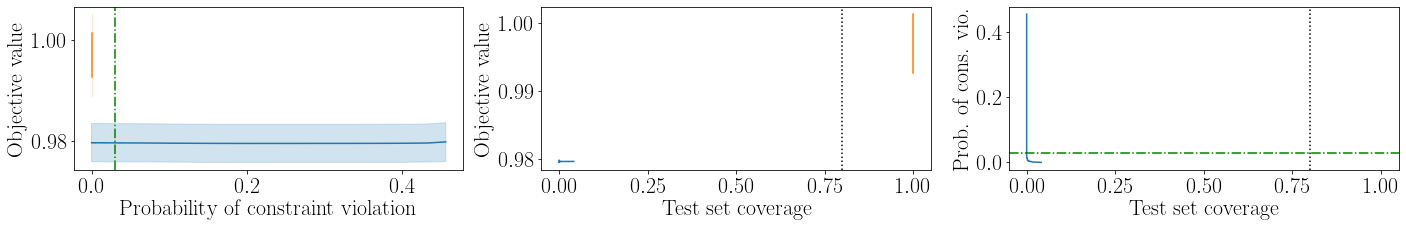

In [10]:
plot_coverage_all(dfgrid,dfgrid2,None, f"results/facility",ind_1=(0,800),ind_2=(50,800
), logscale = False)

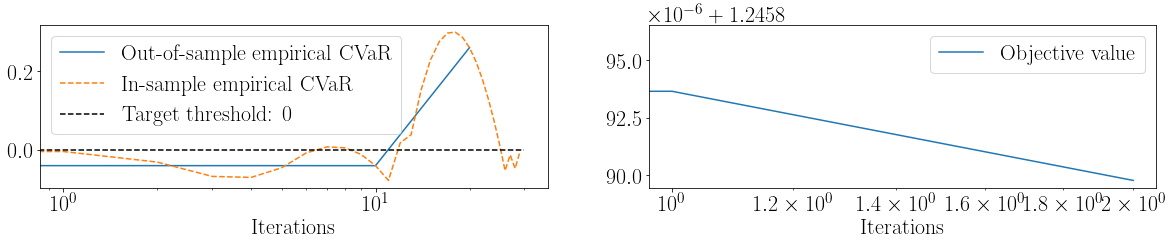

In [8]:
plot_iters(df1,result1.df_test,"facility", steps = 3000)

In [58]:
D = np.vstack([-np.eye(m),np.ones(m), -np.ones(m)])
d = np.hstack([np.zeros(m), 1, -1])

u = lropt.UncertainParameter(m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, rho=1,
                                                                  a=init, b=init_bval, c= D, d = d))

# u = lropt.UncertainParameter(m,
#                                 uncertainty_set = lropt.Ellipsoidal(p=2, rho=1,
#                                                                   a=A_fin, b=b_fin, c= D, d = d))
# formulate cvxpy variable
tau = cp.Variable()
s = cp.Variable(m)
x = cp.Variable(2)
x1 = cp.Variable(2)
x2 = cp.Variable(2)
# normals = cp.Parameter((4,2))
# offsets = cp.Parameter(4)
poi_y = lropt.Parameter((m,2), data = y_data)
poi_y.value = y_data[0]
# formulate problem constants

# formulate objective
objective = cp.Minimize(tau)

constraints = []
# constraints += [normals@x + offsets <= 0]
constraints += [hull.equations[:,:2]@x + hull.equations[:,2] <= 0]
constraints += [hull1.equations[:,:2]@x1 + hull1.equations[:,2] <= 0]
constraints += [hull2.equations[:,:2]@x2 + hull2.equations[:,2] <= 0]
for k in range(m):
      constraints += [s[k] >= cp.norm(x - poi_y[k])]
      constraints += [s[k] >= cp.norm(x1 - poi_y[k])]
      constraints += [s[k] >= cp.norm(x2 - poi_y[k])]
constraints += [s@u <= tau]

      
# formulate Robust Problem
prob = lropt.RobustProblem(objective, constraints,objective_torch=f_tch, constraints_torch=[g_tch], eval_torch=eval_tch)
prob.solve()

1.0368878500026217

In [242]:
vios = []
objs = []
for rho in np.linspace(0.001,5,20):
      totsum = 0
      totval = 0
      for scene in scenarios:
            u = lropt.UncertainParameter(m,
                                          uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = 250))

            # u = lropt.UncertainParameter(m,
            #                                 uncertainty_set = lropt.Ellipsoidal(p=2, 
            #                                                                   rho=1.,A = np.eye(m), b = np.mean(train,axis = 0)))
            # formulate cvxpy variable
            tau = cp.Variable()
            s = cp.Variable(m)
            x = cp.Variable(2)
            x1 = cp.Variable(2)
            x2 = cp.Variable(2)
            normals = cp.Parameter((4,2))
            offsets = cp.Parameter(4)
            normals.value = scenarios[scene][0]
            offsets.value = scenarios[scene][1]
            # formulate problem constants

            # formulate objective
            objective = cp.Minimize(tau)

            constraints = []
            constraints += [normals@x + offsets <= 0]
            constraints += [u@s <= tau]
            constraints += [hull1.equations[:,:2]@x1 + hull1.equations[:,2] <= 0]
            constraints += [hull2.equations[:,:2]@x2 + hull2.equations[:,2] <= 0]
            for k in range(m):
                  constraints += [s[k] >= cp.norm(x - poi[k])]
                  constraints += [s[k] >= cp.norm(x1 - poi[k])]
                  constraints += [s[k] >= cp.norm(x2 - poi[k])]
                  
            # formulate Robust Problem
            prob = lropt.RobustProblem(objective, constraints)
            prob.solve()
            for i in range(250):
                  newsums = torch.where(torch.maximum(torch.tensor(test[i])@torch.tensor(s.value) - tau.value, torch.tensor(0.,requires_grad = True))>=0.0001,torch.tensor(1.), torch.tensor(0.))
                  if newsums >=1:
                        totsum += torch.tensor(1.)/250
            totval += tau.value
      vios.append(totsum/5)
      objs.append(totval/5)

In [9]:
def plot_tradeoff(df_standard,df_reshape,title,ind_1 = (0,100), ind_2 = (0,100),mroobj = None, mrovio = None):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 3))
    ax1.plot(np.mean(np.vstack(df_standard['Violation_val']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['Violation_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violation_val']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['Violation_val']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Reshaped set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['Violation_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violation_val']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.set_xlabel("Empirical $\mathbf{CVaR}$")
    ax1.set_ylabel("Objective value")
    ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Standard set")
    ax2.fill(np.append(np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax2.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
    ax2.fill(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if mroobj:
        ax2.plot(vios, objs, color = "tab:green", label = "DRO")
    ax2.set_xlabel("Probability of constraint violation")
    ax2.set_ylabel("Objective value")
    ax2.set_ylim([-0.1,5])
    ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax2.legend()
    plt.savefig(title+"_curve.pdf",bbox_inches='tight')
    plt.show()

In [14]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax.fill(np.append(np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
    ax.fill(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    ax.set_ylabel("Objective value")
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if dfs:
        for i in range(5):
            ax1.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax1.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    ax1.set_xlabel("Test set coverage")
    ax1.set_ylabel("Objective value")
    # ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)
    if dfs:
        for i in range(5):
            ax2.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax2.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_ylabel("Prob. of cons. vio.")
    ax2.set_xlabel("Test set coverage")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    plt.show()

## Runs

In [243]:
def eval(tau, x,s,x1,x2, normals, offsets, data):
    tau = torch.tensor(tau)
    x = torch.tensor(x)
    s = torch.tensor(s)
    x1 = torch.tensor(x1)
    x2 = torch.tensor(x2)
    normals = torch.tensor(normals)
    offsets = torch.tensor(offsets)
    data = torch.tensor(data)
    totsum = torch.tensor(0.)
    Nsample = data.shape[0]
    for i in range(Nsample):
        newsums = torch.where(torch.maximum(data[i]@s - tau, torch.tensor(0.,requires_grad = True))>=0.0001,torch.tensor(1.), torch.tensor(0.))
        if newsums >=1:
            totsum += torch.tensor(1.)
    return totsum/Nsample

def make_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,6))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))
        # Formulate the Robust Problem
        tau = cp.Variable()
        s = cp.Variable(m)
        x = cp.Variable(2)
        x1 = cp.Variable(2)
        x2 = cp.Variable(2)
        normals = cp.Parameter((4,2))
        offsets = cp.Parameter(4)
        normals.value = scenarios[scene][0]
        offsets.value = scenarios[scene][1]
        # formulate problem constants

        # formulate objective
        objective = cp.Minimize(tau)

        constraints = []
        constraints += [normals@x + offsets <= 0]
        constraints += [u@s <= tau]
        # constraints += [u >= -0.01]
        # for k in range(m):
        #       constraints += [u@(np.eye(m)[k])*s[k] >= 0]
        # constraints += [u@np.ones(m) >= 0.99999]
        constraints += [hull1.equations[:,:2]@x1 + hull1.equations[:,2] <= 0]
        constraints += [hull2.equations[:,:2]@x2 + hull2.equations[:,2] <= 0]
        for k in range(m):
            constraints += [s[k] >= cp.norm(x - poi[k])]
            constraints += [s[k] >= cp.norm(x1 - poi[k])]
            constraints += [s[k] >= cp.norm(x2 - poi[k])]
            
        # formulate Robust Problem
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()

        coverage = 0
        for datind in range(test.shape[0]):
            coverage += np.where(np.linalg.norm((1/r_eps)*result_A@test[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )
        coverage_train = 0
        for datind in range(train.shape[0]):
            coverage_train += np.where(np.linalg.norm((1/r_eps)*result_A@train[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )

        trial1[scene,0] = newprob.objective.value
        tau, x,s,x1,x2, normals, offsets, data
        trial1[scene,1] = eval(tau.value,x.value,s.value, x1.value,x2.value,normals.value,offsets.value,test).item()
        trial1[scene,2] = eval(tau.value,x.value,s.value, x1.value,x2.value,normals.value,offsets.value,train).item()
        trial1[scene,3] = coverage/test.shape[0]
        trial1[scene,4] = coverage_train/train.shape[0]
        trial1[scene,5] = newprob.solver_stats.solve_time
        # trial1[scene,6] = np.linalg.det(sc.linalg.inv((1/r_eps)*result_A@((1/r_eps)*result_A)))**0.5
    return trial1

In [ ]:
dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]

In [ ]:
trial1 = np.zeros((num_scenarios,6))
for scene in range(num_scenarios):
    # formulate the ellipsoidal set
    if eps:
      r_eps = 1
    else:
      r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
    u = lropt.UncertainParameter(m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))
    # Formulate the Robust Problem
    tau = cp.Variable()
    s = cp.Variable(m)
    x = cp.Variable(2)
    x1 = cp.Variable(2)
    x2 = cp.Variable(2)
    normals = cp.Parameter((4,2))
    offsets = cp.Parameter(4)
    normals.value = scenarios[scene][0]
    offsets.value = scenarios[scene][1]
    # formulate problem constants

    # formulate objective
    objective = cp.Minimize(tau)

    constraints = []
    constraints += [normals@x + offsets <= 0]
    constraints += [u@s <= tau]
    # constraints += [u >= -0.01]
    # for k in range(m):
    #       constraints += [u@(np.eye(m)[k])*s[k] >= 0]
    # constraints += [u@np.ones(m) >= 0.99999]
    constraints += [hull1.equations[:,:2]@x1 + hull1.equations[:,2] <= 0]
    constraints += [hull2.equations[:,:2]@x2 + hull2.equations[:,2] <= 0]
    for k in range(m):
        constraints += [s[k] >= cp.norm(x - poi[k])]
        constraints += [s[k] >= cp.norm(x1 - poi[k])]
        constraints += [s[k] >= cp.norm(x2 - poi[k])]
        
    # formulate Robust Problem
    prob = lropt.RobustProblem(objective, constraints)
    newprob = prob.dualize_constraints()
    newprob.solve()

In [283]:
Ar_saved = np.zeros((100,m,m))
br_saved = np.zeros((100,m))
reshaped_table = np.zeros((1,18))
standard_table = np.zeros((1,18))
for experiment in range(10):
    print(experiment)
    np.random.seed(experiment)
    data = np.zeros((500,m))
    for datint in range(500):
        sample = np.random.choice(np.arange(m), p=distribution,size = 500)
        counter = Counter(sample)
        for i in range(m):
            data[datint][i] = counter[i]/500
    # Formulate uncertainty set
    u = lropt.UncertainParameter(m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                  rho=1., data =data, loss =loss))
    # formulate cvxpy variable
    tau = cp.Variable()
    s = cp.Variable(m)
    x = cp.Variable(2)
    x1 = cp.Variable(2)
    x2 = cp.Variable(2)
    normals = cp.Parameter((4,2))
    offsets = cp.Parameter(4)
    # formulate problem constants

    # formulate objective
    objective = cp.Minimize(tau)

    constraints = []
    constraints += [normals@x + offsets <= 0]
    constraints += [u@s <= tau]
    # constraints += [u >= -0.01]
    # for k in range(m):
    #       constraints += [u@(np.eye(m)[k])*s[k] >= 0]
    # constraints += [u@np.ones(m) >= 0.99999]
    constraints += [hull1.equations[:,:2]@x1 + hull1.equations[:,2] <= 0]
    constraints += [hull2.equations[:,:2]@x2 + hull2.equations[:,2] <= 0]
    for k in range(m):
        constraints += [s[k] >= cp.norm(x - poi[k])]
        constraints += [s[k] >= cp.norm(x1 - poi[k])]
        constraints += [s[k] >= cp.norm(x2 - poi[k])]
        
    # formulate Robust Problem
    prob = lropt.RobustProblem(objective, constraints)
    target = -0.05
    # solve
    test_p = 0.5
    seed = 5
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=seed)
    init = np.eye(m)
    init_bval = -np.mean(train, axis=0)
    result1 = prob.train(lr = 0.001, step=300, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = np.eye(m), init_b = -np.mean(train,axis = 0), fixb = False, init_lam = 0.5, target_cvar = target, init_alpha = -0.05, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.1)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    # Grid search epsilon
    result4 = prob.grid(epslst = np.linspace(0.0001, 1, 40), init_A = np.eye(m), init_b = -np.mean(train,axis = 0), seed = seed, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.linspace(0.8,2, 40), init_A = A_fin, init_b = b_fin, seed = seed, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,train,0.03, eps = 0)
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,train,0., eps = 1)
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,train,0.001, eps = 0)
    r_t = np.hstack((r_t, r_t1, r_t2))
    
    reshaped_table = np.vstack((reshaped_table, r_t))

    s_t = make_table(init, init_bval, dfgrid,test, train,0.03, eps = 0)
    s_t2 = make_table(init, init_bval, dfgrid,test, train,0., eps = 1)
    s_t1 = make_table(init, init_bval, dfgrid,test, train,0.001, eps = 0)
    s_t = np.hstack((s_t, s_t1, s_t2))
    standard_table = np.vstack((standard_table, s_t))
    pd.DataFrame(standard_table).to_csv("standard_table.csv")
    pd.DataFrame(reshaped_table).to_csv("reshaped_table.csv")
    # np.save("Ar_saved.npy", Ar_saved)
    # np.save("As_saved.npy", As_saved)
    # np.save("br_saved.npy", br_saved)
    # np.save("bs_saved.npy", bs_saved)
# standard_table = pd.read_csv("standard_table_1.csv").iloc[:,1:]
# reshaped_table = pd.read_csv("reshaped_table_1.csv").iloc[:,1:]
# standard_table = standard_table.values
# reshaped_table = reshaped_table.values
# pd.DataFrame(standard_table).to_csv("standard_table_1.csv")
# pd.DataFrame(reshaped_table).to_csv("reshaped_table_1.csv")
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

0
1
2
3
4
5
6
7
8
9


In [284]:
targets = [0.03,0]
def printresults(table,targets):
  for i in range(2):
    print("test_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 1].reshape(-1, 5), axis=1)))
    print("train_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 2].reshape(-1, 5), axis=1)))
    print("test_obj_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6].reshape(-1, 5), axis=1)))
    print("train_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+4].reshape(-1, 5), axis=1)))
    print("test_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+3].reshape(-1, 5), axis=1)))
    print("solve time " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+5].reshape(-1, 5), axis=1)))
    print(" ")

In [287]:
printresults(reshaped_table,targets)

test_vio_target 0.03:  0.0
train_vio_target 0.03:  0.0
test_obj_target 0.03:  0.873075975336624
train_coverage 0.03:  1.0
test_coverage 0.03:  0.9996
solve time 0.03:  0.0019155740799999999
 
test_vio_target 0:  0.0
train_vio_target 0:  0.0
test_obj_target 0:  0.873075975336624
train_coverage 0:  1.0
test_coverage 0:  0.9996
solve time 0:  0.00188225252
 


In [288]:
printresults(standard_table,targets)

test_vio_target 0.03:  0.0
train_vio_target 0.03:  0.0
test_obj_target 0.03:  0.8889818268052917
train_coverage 0.03:  0.07320000000000002
test_coverage 0.03:  0.06000000000000001
solve time 0.03:  0.00161073998
 
test_vio_target 0:  0.0
train_vio_target 0:  0.0
test_obj_target 0:  0.8889818268052917
train_coverage 0:  0.07320000000000002
test_coverage 0:  0.06000000000000001
solve time 0:  0.0015763367
 


## New

In [173]:
probs = data

In [175]:
def loss(tau, x,s,x1,x2, normals, offsets, alpha, data,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = torch.tensor(0.)
    if len(torch.tensor(data).shape) <2:
        Nsample = 1
        data = [data]
    else:
        Nsample = data.shape[0]
    for i in range(Nsample):
        newsums = 0
        for k in range(m):
            sums += torch.maximum(torch.sum(x - data[i][k:k+2]) - s[k] - alpha, torch.tensor(0.,requires_grad = True))
            sums += torch.maximum(torch.sum(x1 - data[i][k:k+2]) - s[k] - alpha, torch.tensor(0.,requires_grad = True))
            sums += torch.maximum(torch.sum(x2 - data[i][k:k+2]) - s[k] - alpha, torch.tensor(0.,requires_grad = True))

            newsums += torch.where(torch.maximum(torch.sum(x - data[i][k:k+2]) - s[k], torch.tensor(0.,requires_grad = True))>=0.0001,torch.tensor(1.), torch.tensor(0.))
            newsums += torch.where(torch.maximum(torch.sum(x1 - data[i][k:k+2]) - s[k], torch.tensor(0.,requires_grad = True))>=0.0001,torch.tensor(1.), torch.tensor(0.))
            newsums += torch.where(torch.maximum(torch.sum(x2 - data[i][k:k+2]) - s[k], torch.tensor(0.,requires_grad = True))>=0.0001,torch.tensor(1.), torch.tensor(0.))
        if newsums >=1:
            totsum += torch.tensor(1.)
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return tau + torch.tensor(l)*(sums - torch.tensor(target)), tau, totsum/Nsample, sums.detach().numpy()

np.random.seed(5)
data = np.random.rand(500,2*m)*2
p = probs[0]


In [203]:
# formulate the ellipsoidal set
u = lropt.UncertainParameter(2*m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                  rho=1., data =data, loss =loss))
# formulate cvxpy variable
tau = cp.Variable()
s = cp.Variable(m)
x = cp.Variable(2)
x1 = cp.Variable(2)
x2 = cp.Variable(2)
normals = cp.Parameter((4,2))
offsets = cp.Parameter(4)
# formulate problem constants

# formulate objective
objective = cp.Minimize(tau)

constraints = []
constraints += [normals@x + offsets <= 0]
constraints += [p@s <= tau]
# constraints += [u@np.eye(m) >= 0]
constraints += [hull1.equations[:,:2]@x1 + hull1.equations[:,2] <= 0]
constraints += [hull2.equations[:,:2]@x2 + hull2.equations[:,2] <= 0]
for k in range(m):
      constraints += [s[k] >= np.ones(2).T@(x - u@(np.eye(2*m)[k:k+2]).T)]
      # constraints += [s[k] >= np.ones(2).T@(x1 - u@(np.eye(2*m)[k:k+2]).T)]
      # constraints += [s[k] >= np.ones(2).T@(x2 - u@(np.eye(2*m)[k:k+2]).T)]
      
# formulate Robust Problem
prob = lropt.RobustProblem(objective, constraints)
target = -0.01
# solve
test_p = 0.5
seed = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=seed)
init = np.real(sc.linalg.sqrtm(sc.linalg.pinv(np.cov(train.T))))
init_bval = -init@np.mean(train, axis=0)
result1 = prob.train(lr = 0.0001, step=300, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = np.eye(m), init_b = -np.mean(train,axis = 0), fixb = False, init_lam = 0.5, target_cvar = target, init_alpha = -0.01, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.1)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

# result3 = prob.train(eps = True, lr = 0.00001, step=500, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b =0.3*init_bval,  init_lam = 5,target_cvar = target, init_alpha = -0.05, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios,step_y = 0.1)
# df_r2 = result3.df

ValueError: Incompatible dimensions (40, 2) (40, 1)

In [205]:
x

Variable((2,))

In [196]:
np.ones(2)@(np.ones(m)@np.eye(m)[1:3].T)

2.0

In [197]:
print(prob.dualize_constraints())

ValueError: Incompatible dimensions (40, 2) (40, 1)